# Challenge: model comparison
You now know two kinds of regression and two kinds of classifier. So let's use that to compare models!

Comparing models is something data scientists do all the time. There's very rarely just one model that would be possible to run for a given situation, so learning to choose the best one is very important.

Here let's work on regression. Find a data set and build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?

Create a Jupyter notebook with your models. At the end in a markdown cell write a few paragraphs to describe the models' behaviors and why you favor one model or the other. Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. Lastly, try to note what it is about the data that causes the better model to outperform the weaker model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
df = pd.read_csv('USvideos.csv')

df = df[['views', 'title', 'tags', 'likes', 'dislikes', 'comment_count', 'description']].copy()
df['title_len'] = df.title.apply(lambda x: len(str(x))).copy()
df['tags_count'] = df.tags.str.split('|').apply(lambda x: len(x)).copy()
df['description_len'] = df.description.apply(lambda x: len(str(x))).copy()
df['like_dis_ratio'] = df.likes / df.dislikes
df['comment_like_ratio'] = df.comment_count / df.likes
df['comment_dis_ratio'] = df.comment_count / df.dislikes

df = df[['views', 'likes', 'dislikes', 'comment_count', 'title_len', 'tags_count', 'description_len', 'like_dis_ratio',
    'comment_like_ratio', 'comment_dis_ratio']].copy()

df.dropna(inplace=True)

In [3]:
def get_inf(col):
    inf_indexes = df[df[col] == np.inf].index
    return inf_indexes

for col in df.columns[-3:]:
    drop_indexes = get_inf(col)
    df.drop(index=drop_indexes, inplace=True)

In [4]:
df = df[(np.abs(zscore(df)) < 3).all(axis=1)].copy()

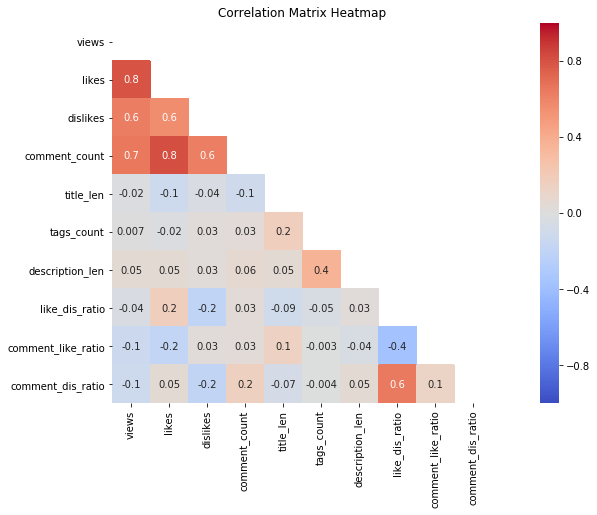

In [5]:
mask = np.triu(df.corr())
plt.figure(figsize=(17,7))
sns.heatmap(df.corr(), annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=mask, square=True)
plt.ylim(df.corr().shape[1], 0)
plt.title('Correlation Matrix Heatmap')
plt.show()

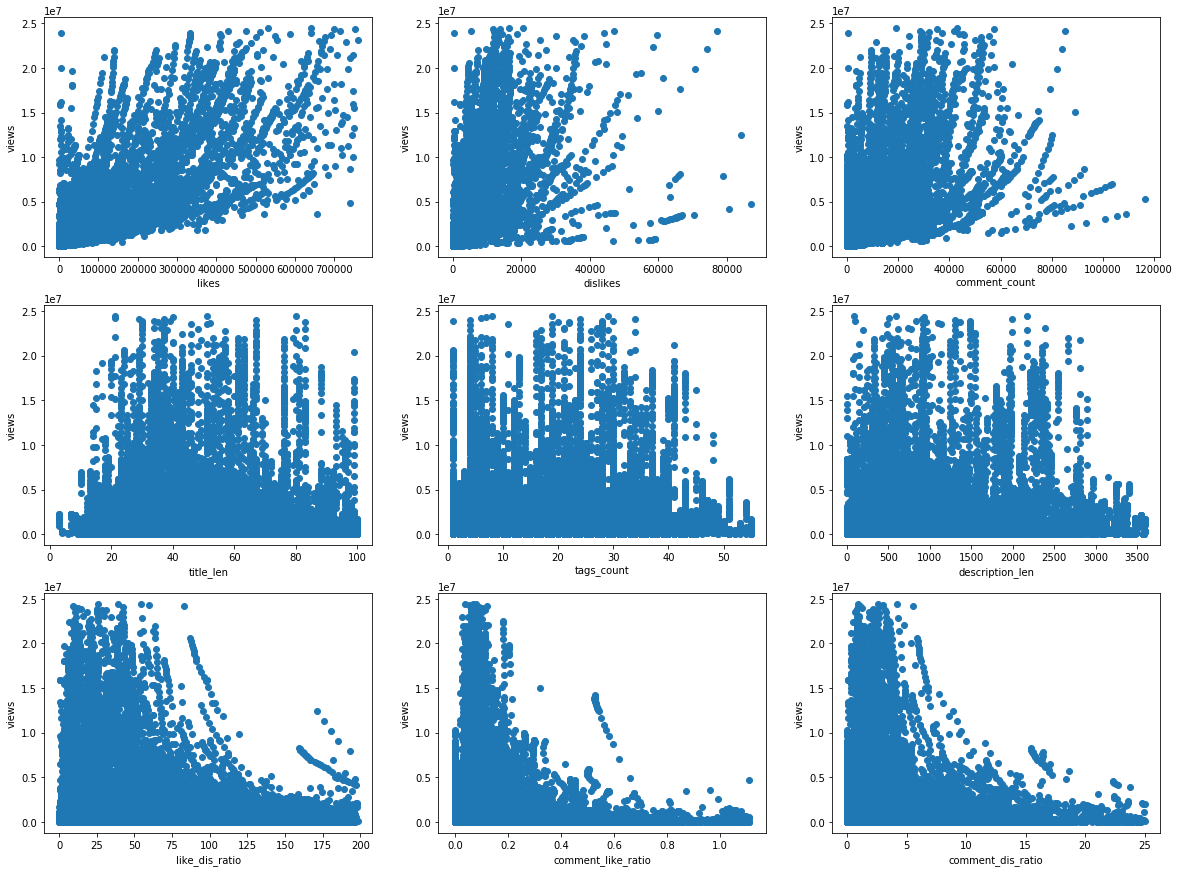

In [6]:
plt.figure(figsize=(20, 15))
for i, col in enumerate(df.columns[1:], 1):
    plt.subplot(3, 3, i)
    plt.scatter(df[col], df.views)
    plt.xlabel(col)
    plt.ylabel('views')
plt.show()

In [7]:
X = df.iloc[:, 1:]
Y = df['views']

In [8]:
linreg = LinearRegression(normalize=True)
knnreg = KNeighborsRegressor(n_neighbors=20, weights='distance')

In [9]:
def quick_eval(model):
    print('-----', str(type(model)).split('.')[-1].replace("'>", ''), '-----')
    print(model.get_params())
    print('Cross Validation: {}'.format(cross_val_score(model, X, Y, cv=5)))
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3, random_state=324)
    model.fit(X_train, Y_train)
    Y_preds = model.predict(X_test)
    mae = mean_absolute_error(Y_test, model.predict(X_test))
    mse = mean_squared_error(Y_test, model.predict(X_test))
    r2 = r2_score(Y_test, model.predict(X_test))
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'R^2: {r2}')
    plt.scatter(Y_test, Y_preds)
    plt.plot(Y_test, Y_test, color='red')
    plt.ylabel('Predictions')
    plt.xlabel('Actual')
    plt.title('Predicitons v Actual')
    plt.show()

----- LinearRegression -----
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': True}
Cross Validation: [0.60343307 0.61030129 0.64923502 0.70857762 0.65456019]
MAE: 785983.7797338828
MSE: 2354056369973.6274
R^2: 0.7177711642015192


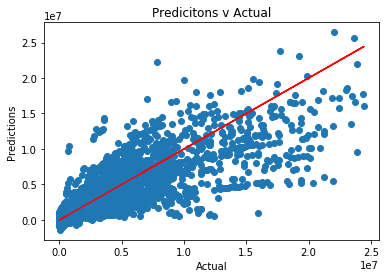

----- KNeighborsRegressor -----
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 20, 'p': 2, 'weights': 'distance'}
Cross Validation: [0.6149761  0.60545216 0.62065145 0.67249918 0.61123212]
MAE: 593697.1677095636
MSE: 1674981265167.186
R^2: 0.7991857720647116


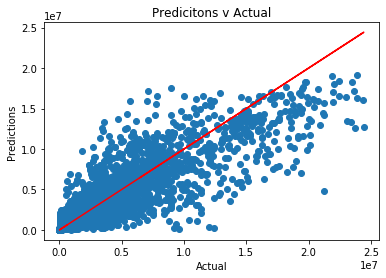

In [10]:
quick_eval(linreg)
quick_eval(knnreg)

In [11]:
X = df.iloc[:, 1:4].copy()
Y = df.views.copy()

----- LinearRegression -----
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': True}
Cross Validation: [0.60200167 0.60536917 0.63958236 0.6900582  0.63592735]
MAE: 768941.1998216751
MSE: 2497339533624.314
R^2: 0.700592883773549


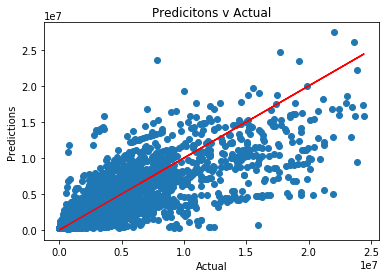

----- KNeighborsRegressor -----
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 20, 'p': 2, 'weights': 'distance'}
Cross Validation: [0.60762306 0.60543925 0.62580827 0.67409937 0.6116839 ]
MAE: 607230.0653102678
MSE: 1713200404168.455
R^2: 0.7946036629686286


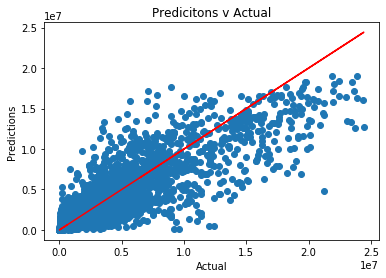

In [12]:
quick_eval(linreg)
quick_eval(knnreg)

It looks to me like the best model for this particular set happens to be the KNN regressor. Doesn't have the greatest predictive power, but it isn't terrible either.